<a href="https://colab.research.google.com/github/blago7272/chocolate-ai/blob/main/BoulevardBulgaria_Implementation_logic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AI Проект за оптимизиране на работния процес в Boulevard Bulgaria

## Въведение
Целта на проекта е създаване на програмно решение, обработващо предварително дефиниран набор от статии, с крайна цел генериране на текстови предложения към редакторите, чрез използване на различни промпт модификации.

Като първа итерация на проекта са имплементирани инструменти на OpenAI, с цел по-лесна и бърза интеграция и максимално бързо достигане до възможност за тестване.

##Сценарии при реализиране на проекта##
При създаването на проекта изникнайа следните променливи, които потенциално биха имали значение за крайния резултат на проекта:

###Chunking стратегия###
<details>
Решението как да бъдат чънкнати файловете на части е с цел оптимизиране работата на семантичното и ценова ефективност.
Към момента VectorStore поддържа максимален размер от 800 на токъните във всеки chunk.
Тъй като почти всички статии са с много по-голяма дължина, измерена в tokens, то се налага прилагане на chunking strategy.

При реализацията на проекта бяха тествани два подхода:
1. **OpenAI Auto Chunking Strategy**
Използване на предлаганата от OpenAI *Auto Chunking Strategy*, с
 параметри:
`max_chunk_size_tokens` = 800
`chunk_overlap_tokens` = 400

**Предимство** на тази стратегия е, че VectorStore изпълнява цялата chunking процедура.

**Недостатък** на стратегията е, че не можем да подадем метаданни кой chunk към коя статия принадлежи, нито къде е началото/края на всеки от тях.

По тази причина, след първоначалните тестове, изпълнихме наша chunking strategy, която описваме по-долу,

2. **Custom chinking stragegy**
На база обработения HTML текст, всеки негов параграф се превръщаше в отделен chunk.

За всеки chunk се генерираше мета-информация, предоставяща информация кой по ред chunk е това, от коя позиция започва и свършва, със следния примерен формат:

````
{
      "id": "30094",
      "content": "**Куршум или отломка от куршум?** ...
      "metadata": {
        "created_at": "2024-07-27T14:14:17.000+03:00",
        "ChunkOrder": 1,
        "StartPosition": 1,
        "EndPosition": 109
      }
````

Основната цел е лесен за импорт в други платформи формат. Стриктно за целите на OpenAI теста могат да се използват и други подходи за реализация.

Един от въпросите за бъдещо подобрение на резултатите от проекта ще бъде каква е оптималната chinking стратегия, според целите.
За да може да се даде отговор на въпроса, се налага да създадем формален процес за тестване резултатите от работата на модела.
</details>

###Избор на Мета-данни###
<details>
Изборът на мета-данни и работата с тях е следващата важна променлива в бъдещото развитие на модела.

За целите на настоящия проект не сме използвали нищо от първоначално предоставените ни мета-данни, тъй като освен списъка с тагове, нищо от тях не ни се видя потенциално полезно за работата на модела.

Обект на бъдеща дискусия е как може да бъде подобрено съдържанието на Булевард България, чрез добавяне на богати мета-данни.

Примерен вариант е обработка на цялото съдържание през LLM модел, с различни промптове и генериране на мета-данни за него.

Друг вариант е използване на външни източници (Търговски регистър) и свързането на данните от него със статиите на Булевард България.
</details>

###Промптове към Асистентите###
<details>
OpenAI позволява много лесно създаване на различни Асистенти, работещи с добавените данни.
Всеки Асистент може да има различен prompt, който реализира подобни, но нюансирани отговори, насочени напр. към анализ на хора, събития, създаване на булетирано резюме или статия и т.н.
</details>

##Архитектура на проекта##
За  целите на проекта се използват следните ресурси:

[Files](https://platform.openai.com/docs/api-reference/files)
<br>
[VectorStore](https://platform.openai.com/docs/api-reference/vector-stores)
<br>
[Assistants](https://platform.openai.com/docs/api-reference/assistants)


###Files###
<details>
Използваме OpenAPI, за да добавяме и управляваме съдържанието на нашите статии. Като краен резултат от операцията, получаваме списък с вътрешни идентификатори, които можем да използваме при втората стъпка - асоцииране на статиите с VectorStore и добавяне на мета-данни за тях.

В допълнение, можем да използваме многократно съдържанието на статиите, за да тестваме ефектът от добавяне на различни комбинации от мета-данни върху работата на асистентите.
</details>

###Използване на VectorStore за семантично търсене в статиите###
<details>
След като сме добавили статиите в OpenAI екосистемата, ще използваме VectorStore за реализиране на семантично търсене.

В ранна версия на проекта, използвахме филтър по семантична идентичност. На първа стъпка, потребителят въвеждаше фраза, по която да се направи първоначалното филтриране на статиите, след което на база семантичен индекс (score), класираните топ N статии се подаваха към избрам LLM модел, заедно с втори потребителски prompt, който служеше за оценка на извлечената информация.

При ограничените тестове, които проведохме, по-добри резултати даде модел, в който подаваме на LLM чънкове от статии и универсален prompt. Този подход изглежда и по-лесен за работа от редакторите.
</details>

###Последваща обработка във Assistants###
<details>
VectorStore се свързва нативно с т.нар. Асистенти, друг инструмент на OpenAI, който дава възможност за семантичен анализ и класиране по релевантност на съдържанието на статиите (или chunks от тях).

Извлечените селектирани статии (chunks) се подават през OpenAI Assistants към избран LLM модел, който обработва потребителският prompt, използвайки информация в статиите и връща съответните отговори.
</details>

###Блох-схема на операциите###

Блок-схема на описаните по-долу операции.

<details>

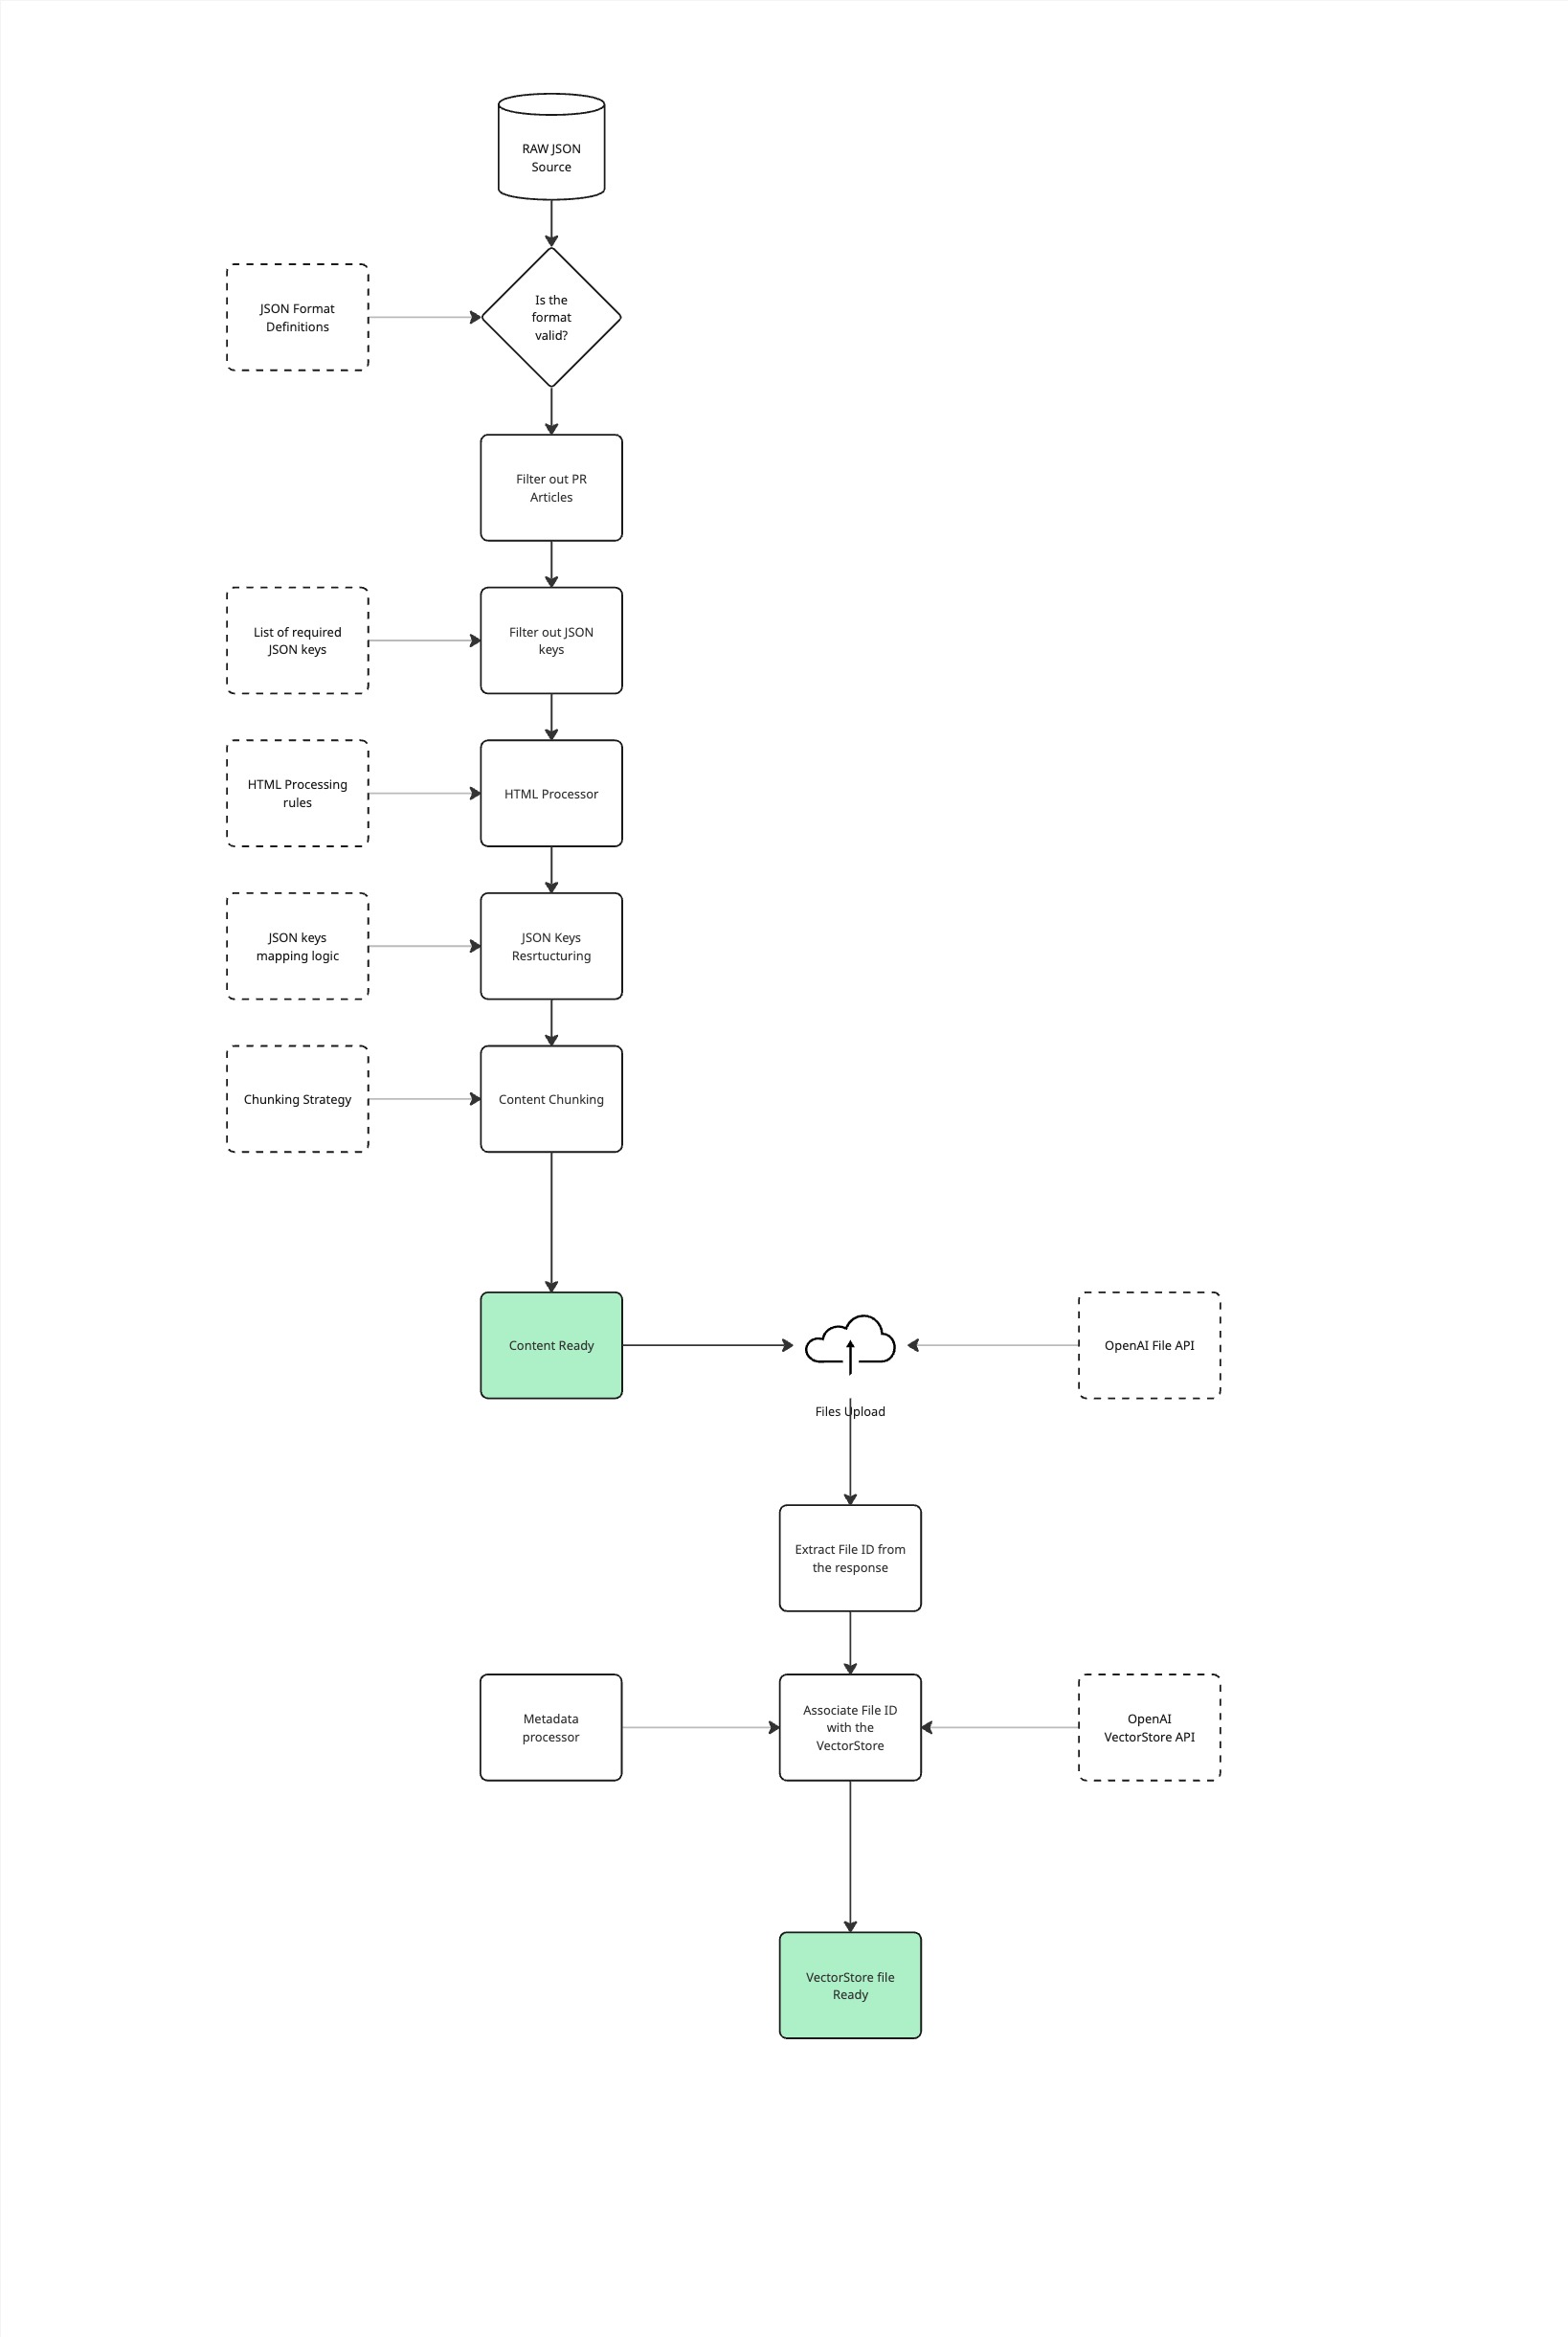

</details>

##Обработка на суровите данни##
Използваният формат, от който сме импортирали статиите e JSON (виж приложения файл).

За да подготвим данните от файла, сме приложили обработка на няколко стъпки. Част от тези стъпки могат да бъдат прескочени от екипа на Булевард България, като информацията за статиите бъде форматирана по различен начин.

###Първа стъпка###

Първата приложена от нас обработка беше премахване на PR статиите.

Филтрирането на PR статиите е опционално, според желанието на BB, като за целите на нашите тестове сме ги премахнали.

In [ ]:
import json
import os
import re
import io
import zipfile
from google.colab import files, drive

def process_uploaded_files():
    # Ask user if they want to use Drive or regular file upload
    storage_choice = input("Where are your JSON files located?\n1. Upload from my computer\n2. Access from Google Drive\nEnter choice (1 or 2): ")

    if storage_choice == '1':
        # Upload files approach
        print("Please upload your JSON files")
        uploaded = files.upload()

        # Create a temporary directory to store uploaded files
        temp_dir = 'temp_uploads'
        os.makedirs(temp_dir, exist_ok=True)

        # Store the uploaded files in the temporary directory
        for filename, content in uploaded.items():
            with open(os.path.join(temp_dir, filename), 'wb') as f:
                f.write(content)

        directory = temp_dir

    elif storage_choice == '2':
        # Google Drive approach
        drive.mount('/content/drive')
        drive_path = input("Enter the path to your files in Google Drive (e.g., 'MyDrive/my_folder'): ")
        directory = f'/content/drive/{drive_path}'

        if not os.path.exists(directory):
            print(f"Path {directory} not found. Please check and try again.")
            return

    else:
        print("Invalid choice. Please run the script again.")
        return

    # Process files in the directory
    pattern = re.compile(r'split_data_(\d+)\.json$')
    deletion_plan = {}

    # Check if any matching files exist
    matching_files = [f for f in os.listdir(directory) if pattern.match(f)]
    if not matching_files:
        print(f"\n\033[1;31mNo matching 'split_data_XX.json' files found in the directory!\033[0m")
        return

    # First pass: collect deletion information
    for filename in matching_files:
        filepath = os.path.join(directory, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception as e:
            print(f"\n\033[1;31mError reading {filename}: {str(e)}\033[0m")
            continue

        to_delete = []
        for doc in data.get('documents', []):
            # Check if sponsorship exists and is explicitly set to a truthy value
            if doc.get('metadata', {}).get('sponsorship'):
                to_delete.append({
                    'id': doc.get('id', 'NO_ID'),
                    'title': doc.get('metadata', {}).get('title', 'Untitled')
                })

        if to_delete:
            # Keep all original data structure
            filtered_data = data.copy()
            # Replace only the documents array with filtered version
            filtered_data['documents'] = [doc for doc in data.get('documents', [])
                                         if not doc.get('metadata', {}).get('sponsorship')]

            deletion_plan[filepath] = {
                'original_data': data,
                'filtered_data': filtered_data,
                'deletions': to_delete
            }

    # Show deletion preview
    if deletion_plan:
        print("\n\033[1;31mPLANNED DELETIONS:\033[0m")
        for filepath, plan in deletion_plan.items():
            print(f"\n\033[1mFile: {os.path.basename(filepath)}\033[0m")
            for item in plan['deletions']:
                print(f"  │ ID: {item['id']}")
                print(f"  │ Title: {item['title']}")
                print(f"  └{'─'*50}")

            original_count = len(plan['original_data'].get('documents', []))
            filtered_count = len(plan['filtered_data'].get('documents', []))
            print(f"  Total: {original_count - filtered_count} articles will be removed from {original_count} total")
    else:
        print("\n\033[1;32mNo sponsored articles found!\033[0m")
        return

    # Ask user where to save the results
    save_choice = input("\nWhere would you like to save the filtered files?\n1. Download to my computer\n2. Save to Google Drive\n3. Save in the same location as source files\nEnter choice (1, 2, or 3): ")

    # Confirmation
    print("\n\033[1;31mWARNING: This will create filtered versions of the files with sponsored content removed!\033[0m")
    confirmation = input("Type 'CONFIRM' to proceed: ")

    # Second pass: apply deletions
    if confirmation == 'CONFIRM':
        # Create a directory for filtered files if downloading or saving to Drive
        if save_choice == '1':
            output_dir = 'filtered_files'
            os.makedirs(output_dir, exist_ok=True)
        elif save_choice == '2':
            drive_output_path = input("Enter the path in Google Drive to save filtered files (e.g., 'MyDrive/filtered_folder'): ")
            output_dir = f'/content/drive/{drive_output_path}'
            os.makedirs(output_dir, exist_ok=True)

        # Process all files
        filtered_files = []
        for filepath, plan in deletion_plan.items():
            filename = os.path.basename(filepath)

            if save_choice == '1' or save_choice == '2':
                # Save to output directory
                output_path = os.path.join(output_dir, f'filtered_{filename}')
                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(plan['filtered_data'], f, ensure_ascii=False, indent=2)
                filtered_files.append(output_path)
            elif save_choice == '3':
                # Save in the same location with a prefix

                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(plan['filtered_data'], f, ensure_ascii=False, indent=2)
                filtered_files.append(output_path)

            print(f"\n\033[31mRemoved {len(plan['deletions'])} sponsored articles from {filename}\033[0m")

        # If downloading to computer, create a zip file
        if save_choice == '1':
            zip_path = 'filtered_files.zip'
            with zipfile.ZipFile(zip_path, 'w') as zipf:
                for file in filtered_files:
                    zipf.write(file, os.path.basename(file))

            # Trigger download
            files.download(zip_path)
            print(f"\n\033[1;32mDownloaded zip file with all filtered results\033[0m")
        elif save_choice == '2':
            print(f"\n\033[1;32mSaved filtered files to Google Drive at {output_dir}\033[0m")
        else:
            print(f"\n\033[1;32mSaved filtered files with 'filtered_' prefix in the same location\033[0m")

        print("\n\033[1;32mOperation completed successfully\033[0m")
    else:
        print("\n\033[1;32mOperation cancelled\033[0m")

# Run the function
if __name__ == "__main__":
    process_uploaded_files()

###Втора стъпка - Преработка на HTML в текст###

Тази стъпка е важна, тъй като очакваме да има влияние върху крайният резулат от работата на модела.

Използването на HTML маркирани статии прави смисъл, защото то отразява виждането на редактора, създал съответната статия, за логическото подреждане на текста в нея.

**Обект на допълнителна дискусия е как можем да модифицираме тази стъпка. **

Прилагаме примерен скрипт,  работещ с `content` и превръща HTML в текст. Следва детайлно описание на промените, които скриптът прави:
<details>
* Преобразуване на блок-елементите `<p>, <div>, <h1>-<h6>` → превръща ги в newlines (\n).
* Всеки затварящ `</li>` и отварящ `<li>` се заменят с нов ред (\n).
* Отварящите и затварящите тагове `<ul>, </ul>, <ol>, </ol>` се заменят с двойни нови редове (\n\n), за да се отделят ясно от останалия текст.
* Таблиците, дефинирани от HTML елементи `<tr>, <td>` → Превръща ги в структуриран текстови формат, използвайки | за отделните колони
*  Текстовете в Bold `<strong>, <b>` → опаковат се с **text**.
* Текстовете с Italic `<em>, <i>` → опаковат се с _text_.
* Новите редове `<br>` → Заместват се с  `\n`.
* Останалите HTML тагове се премахват изцяло.
* HTML entities (e.g., &nbsp;, &amp;) → Превръщат се в техните еквиваленти:
`&nbsp;` → интервал
`&amp;` → &
`&lt;` → <
`&gt;` → >

* Нормализиране на броя нови редове `\n\n\n → \n\n`.
* Премахват се излишните интервали във всеки ред (повече от един).
* Прехват се първите и последните (излишни) интервали във всеки ред.
</details>

In [ ]:
import json
import re
from html import unescape
from google.colab import files, drive
import os

# Formatting configuration
DEFAULT_FORMAT_RULES = {
    'bold': {
        'description': 'Bold text (<strong>, <b>)',
        'patterns': [r'<strong>(.*?)<\/strong>', r'<b>(.*?)<\/b>'],
        'default_replacement': r'**\1**'
    },
    'italic': {
        'description': 'Italic text (<em>, <i>)',
        'patterns': [r'<em>(.*?)<\/em>', r'<i>(.*?)<\/i>'],
        'default_replacement': r'_\1_'
    },
    'links': {
        'description': 'Hyperlinks (<a href>)',
        'patterns': [r'<a href="(.*?)">(.*?)<\/a>'],
        'default_replacement': r'[\2](\1)'
    }
}

def get_user_formatting_preferences():
    """Ask user which formatting rules they want to override"""
    print("\nCurrent formatting rules:")
    for i, (rule_name, rule) in enumerate(DEFAULT_FORMAT_RULES.items(), 1):
        print(f"{i}. {rule['description']} → {rule['default_replacement']}")

    print("\nWhich formatting rule would you like to change? (Enter number, or 0 to keep all defaults)")
    choice = input("Your choice: ")

    if not choice.isdigit() or int(choice) < 0 or int(choice) > len(DEFAULT_FORMAT_RULES):
        print("Keeping all default formatting rules.")
        return DEFAULT_FORMAT_RULES

    choice_idx = int(choice) - 1
    if choice_idx == -1:
        return DEFAULT_FORMAT_RULES

    rule_name = list(DEFAULT_FORMAT_RULES.keys())[choice_idx]
    rule = DEFAULT_FORMAT_RULES[rule_name]

    print(f"\nCurrent replacement for {rule['description']}: {rule['default_replacement']}")
    new_replacement = input(f"Enter new replacement pattern (use \\1 for captured group): ")

    if not new_replacement:
        print("Keeping default replacement.")
        return DEFAULT_FORMAT_RULES

    # Create a copy of the rules with the user's modification
    modified_rules = DEFAULT_FORMAT_RULES.copy()
    modified_rules[rule_name] = {
        **rule,
        'default_replacement': new_replacement
    }

    return modified_rules

def clean_html_content(html_content, format_rules):
    """Clean HTML content using specified formatting rules"""
    if not isinstance(html_content, str):
        return html_content

    # Replace block-level elements with newlines
    html_content = re.sub(r'<\/p>\s*<p>', '\n\n', html_content)
    html_content = re.sub(r'<\/?h[1-6]>', '\n\n', html_content)
    html_content = re.sub(r'<br\s*\/?>|<\/br>', '\n', html_content)
    html_content = re.sub(r'<\/li>\s*<li>', '\n', html_content)
    html_content = re.sub(r'<\/?[uo]l>', '\n\n', html_content)
    html_content = re.sub(r'<\/div>\s*<div>', '\n', html_content)
    html_content = re.sub(r'<\/tr>\s*<tr>', '\n', html_content)
    html_content = re.sub(r'<\/td>\s*<td>', ' | ', html_content)

    # Apply user-specified formatting rules
    for rule in format_rules.values():
        for pattern in rule['patterns']:
            html_content = re.sub(pattern, rule['default_replacement'], html_content)

    # Remove remaining HTML tags
    html_content = re.sub(r'<.*?>', '', html_content)

    # Replace HTML entities
    html_content = unescape(html_content)

    # Normalize whitespace
    html_content = re.sub(r'\n{3,}', '\n\n', html_content)
    html_content = re.sub(r'[ \t]+', ' ', html_content)
    lines = [line.strip() for line in html_content.split('\n')]
    html_content = '\n'.join(lines)

    return html_content.strip()

def get_input_file():
    """Get input file from user (Google Drive or local upload)"""
    print("Where is your input file located?")
    print("1. Upload from my computer")
    print("2. Google Drive")
    choice = input("Enter choice (1 or 2): ")

    if choice == '1':
        print("Please upload your JSON file")
        uploaded = files.upload()
        if not uploaded:
            raise ValueError("No file uploaded")
        filename = next(iter(uploaded))
        return filename, uploaded[filename]
    elif choice == '2':
        drive.mount('/content/drive')
        drive_path = input("Enter path in Google Drive (e.g., 'MyDrive/folder/file.json'): ")
        full_path = f'/content/drive/{drive_path}'
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"File not found: {full_path}")
        with open(full_path, 'r', encoding='utf-8') as f:
            content = f.read()
        return full_path, content
    else:
        raise ValueError("Invalid choice")

def save_output_file(cleaned_data, original_path):
    """Save output file based on original source"""
    print("\nWhere should we save the cleaned file?")
    print("1. Download to my computer")
    print("2. Save to Google Drive (same location as original)")
    choice = input("Enter choice (1 or 2): ")

    output_filename = f"cleaned_{os.path.basename(original_path)}"

    if choice == '1':
        output_path = output_filename
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(cleaned_data, f, ensure_ascii=False, indent=2)
        files.download(output_path)
        print(f"File downloaded as {output_path}")
    elif choice == '2':
        if not original_path.startswith('/content/drive/'):
            print("Original file wasn't from Google Drive. Downloading instead.")
            output_path = output_filename
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(cleaned_data, f, ensure_ascii=False, indent=2)
            files.download(output_path)
        else:
            drive_dir = os.path.dirname(original_path)
            output_path = os.path.join(drive_dir, output_filename)
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(cleaned_data, f, ensure_ascii=False, indent=2)
            print(f"File saved to Google Drive: {output_path}")
    else:
        print("Invalid choice. File not saved.")

def main():
    print("=== HTML Content Cleaner for JSON Files ===")

    try:
        # Get input file
        input_path, file_content = get_input_file()

        # Load JSON data
        try:
            data = json.loads(file_content)
        except json.JSONDecodeError as e:
            print(f"Error: Invalid JSON file - {str(e)}")
            return

        # Get user formatting preferences
        format_rules = get_user_formatting_preferences()

        # Process data
        if isinstance(data, list):
            for item in data:
                if 'content' in item:
                    item['content'] = clean_html_content(item['content'], format_rules)
        elif isinstance(data, dict):
            if 'content' in data:
                data['content'] = clean_html_content(data['content'], format_rules)
            if 'documents' in data:  # Special case for document collections
                for doc in data['documents']:
                    if 'content' in doc:
                        doc['content'] = clean_html_content(doc['content'], format_rules)

        # Save output
        save_output_file(data, input_path)
        print("\nCleaning completed successfully!")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Operation failed. Please check your input and try again.")

if __name__ == "__main__":
    main()

=== HTML Content Cleaner for JSON Files ===
Where is your input file located?
1. Upload from my computer
2. Google Drive
Enter choice (1 or 2): 1
Please upload your JSON file


Saving BoulevardBulgaria--articles--all_first_5.json to BoulevardBulgaria--articles--all_first_5.json

Current formatting rules:
1. Bold text (<strong>, <b>) → **\1**
2. Italic text (<em>, <i>) → _\1_
3. Hyperlinks (<a href>) → [\2](\1)

Which formatting rule would you like to change? (Enter number, or 0 to keep all defaults)
Your choice: 0

Where should we save the cleaned file?
1. Download to my computer
2. Save to Google Drive (same location as original)
Enter choice (1 or 2): 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded as cleaned_BoulevardBulgaria--articles--all_first_5.json

Cleaning completed successfully!


##Трета стъпка - Филтриране на излишните полета##

 Следващата стъпка е премахването на полетата, които няма да използваме и конвертирането на JSON структурата в подходящ за VectorStore формат, използващ обекта `metadata` за съхранение на мета-данните.

 Стъпката може да бъде игнорирана от екипа на Булевард България, тъй като те директно могат да генерират необходимия формат и обем на данните.

 **Важна дискусия тук е кои полета искаме да използваме като мета-данни.**



In [ ]:
import json
from google.colab import drive, files

def load_json_file():
    """Prompt user to upload a JSON file from computer or Google Drive"""
    print("Choose file source:")
    print("1. Upload from computer")
    print("2. Load from Google Drive")
    choice = input("Enter your choice (1 or 2): ")

    if choice == '1':
        uploaded = files.upload()
        file_name = next(iter(uploaded))
        with open(file_name, 'r', encoding='utf-8') as f:
            return json.load(f)
    elif choice == '2':
        drive.mount('/content/drive')
        file_path = input("Enter path to file in Google Drive (e.g., /content/drive/MyDrive/data.json): ")
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    else:
        print("Invalid choice")
        return None

def select_metadata_keys(all_keys):
    """Prompt user to select which metadata keys to keep"""
    print("\nAvailable keys in the data:")
    for i, key in enumerate(all_keys, 1):
        print(f"{i}. {key}")

    # Always keep these required keys
    required_keys = {'id', 'content'}
    selected = required_keys.copy()

    print("\nThese keys will be kept automatically: id, content")
    print("Select additional keys to include in metadata (comma-separated numbers):")
    choices = input("Or press Enter to skip: ")

    if choices.strip():
        indices = [int(i.strip()) - 1 for i in choices.split(',')]
        for i in indices:
            if 0 <= i < len(all_keys):
                selected.add(all_keys[i])

    return sorted(selected)

def validate_key(key):
    """Check if key meets length requirement"""
    if len(key.encode('utf-8')) > 64:
        print(f"Error: Key '{key}' exceeds 64 bytes when encoded")
        new_key = input("Please enter a shorter replacement key (or press Enter to skip): ")
        return new_key if new_key else None
    return key

def process_value(value, key):
    """Check and optionally truncate values"""
    if value is None:
        return ""

    str_value = str(value)
    if len(str_value.encode('utf-8')) > 512:
        print(f"Warning: Value for '{key}' exceeds 512 bytes")
        choice = input("Truncate to 512 bytes? (y/n): ").lower()
        if choice == 'y':
            # Truncate while preserving UTF-8 characters
            encoded = str_value.encode('utf-8')[:512]
            return encoded.decode('utf-8', 'ignore').rstrip('\x00')
        return str_value
    return str_value

def transform_data(data, selected_keys):
    """Transform the data into retrieval-ready format"""
    documents = []

    for article in data:
        # Ensure required fields exist
        if 'id' not in article or 'content' not in article:
            continue

        doc_id = str(article['id'])
        content = str(article['content'])

        # Build metadata with selected keys
        metadata = {}
        for key in selected_keys:
            if key in {'id', 'content'}:
                continue

            if key in article:
                metadata[key] = process_value(article[key], key)

        documents.append({
            "id": doc_id,
            "content": content,
            "metadata": metadata
        })

    return {"documents": documents}

def main():
    # Step 1: Load JSON data
    print("=== Article Data Transformer ===")
    data = load_json_file()
    if not data:
        return

    # Step 2: Get all unique keys
    all_keys = set()
    for article in data:
        all_keys.update(article.keys())
    all_keys = sorted(all_keys)

    # Step 3: Let user select keys
    selected_keys = select_metadata_keys(all_keys)

    # Step 4: Validate keys
    validated_keys = ['id', 'content']  # These are required
    for key in selected_keys:
        if key in {'id', 'content'}:
            continue

        valid_key = validate_key(key)
        if valid_key and valid_key not in validated_keys:
            validated_keys.append(valid_key)

    print("\nFinal selected keys:", ', '.join(validated_keys))

    # Step 5: Transform data
    output_data = transform_data(data, validated_keys)

    # Step 6: Save output
    output_filename = input("\nEnter output filename (e.g., retrieval_ready.json): ")
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, ensure_ascii=False, indent=2)

    print(f"\nSuccess! {len(output_data['documents'])} documents saved to {output_filename}")

    # For Google Colab: Offer download
    if input("Download the file now? (y/n): ").lower() == 'y':
        files.download(output_filename)

if __name__ == "__main__":
    main()

=== Article Data Transformer ===
Choose file source:
1. Upload from computer
2. Load from Google Drive
Enter your choice (1 or 2): 1


Saving BoulevardBulgaria--articles--all_first_5.json to BoulevardBulgaria--articles--all_first_5 (1).json

Available keys in the data:
1. alias
2. aside_ads
3. audio_id
4. author_id
5. category_id
6. content
7. created_at
8. exclusive
9. gallery_id
10. gallery_layout
11. id
12. layout
13. meta_description
14. meta_keywords
15. picture_id
16. pr
17. publish_at
18. slug
19. sponsorship
20. status
21. summary
22. tag_list
23. text_ads
24. title
25. title_position
26. updated_at
27. user_id
28. video_id
29. views_count

These keys will be kept automatically: id, content
Select additional keys to include in metadata (comma-separated numbers):
Or press Enter to skip: 4,5,7,22

Final selected keys: id, content, author_id, category_id, created_at, tag_list

Enter output filename (e.g., retrieval_ready.json): retrieval_ready.json

Success! 5 documents saved to retrieval_ready.json
Download the file now? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Четвъртата стъпка##

Ключова следващата стъпка е прилагането на избраната chunking strategy за `content`, с която да оптимизираме работата на VectorStore или друго използвано от нас приложение за векторизиране.

За настоящата итерация на проекта сме използвали проста логика за разделяне - на параграфи, използвайки newline като идентификатор за границите на всеки chunk.
<details>
По-конкретно, скриптът ще търси:
*  `\n `(Unix/Linux/macOS newline)
*  `\r\n` (Windows newline)
*  `\r` (Old Mac newline)
</details>

За всеки така дефиниран chunk, скриптът ще добави мета-данни в `metadata`
обекта, по следния начин:
```
"documents": [
    {
      "id": "30094",
      "content": "**Куршум или отломка от...
      "metadata": {
        "created_at": "2024-07-27T14:14:17.000+03:00",
        "ChunkOrder": 1,
        "StartPosition": 1,
        "EndPosition": 109
      }
```
Крайният резултат ще е преработен файл, който ще копира мета-данните, избрани на предишната стъпка, но ще добави логика зa chunk-ване.


In [ ]:
import json
import re
from google.colab import files
from google.colab import drive
from IPython.display import clear_output

def chunk_articles(content):
    """Split content into chunks with positions using universal newline handling"""
    chunks = []
    start = 0

    # Find all newline sequences (supports \n, \r\n, and \r)
    for match in re.finditer(r'\r\n|\n|\r', content):
        end = match.start()
        if end > start:  # Non-empty chunk
            chunks.append({
                'text': content[start:end],
                'start': start,
                'end': end
            })
        start = match.end()

    # Add final chunk
    if start < len(content):
        chunks.append({
            'text': content[start:],
            'start': start,
            'end': len(content)
        })

    return chunks

def validate_json_structure(data):
    """Check if JSON has the correct structure for VectorStore"""
    if not isinstance(data, dict):
        return False
    if 'documents' not in data:
        return False
    if not isinstance(data['documents'], list):
        return False

    for doc in data['documents']:
        if not all(key in doc for key in ['id', 'content']):
            return False
        if 'metadata' not in doc:
            return False

    return True

def process_file(uploaded_file):
    """Process the uploaded JSON file"""
    try:
        # Read the uploaded file
        data = json.load(uploaded_file)

        # Validate structure
        if not validate_json_structure(data):
            print("Error: Invalid JSON structure. Expected format:")
            print("""
{
  "documents": [
    {
      "id": "unique_id",
      "content": "text content",
      "metadata": {
        "key1": "value1",
        "key2": "value2"
      }
    }
  ]
}""")
            return None

        new_documents = []

        for doc in data['documents']:
            content = doc.get('content', '')
            chunks = chunk_articles(content)

            for i, chunk in enumerate(chunks):
                if not chunk['text'].strip():
                    continue

                # Use 1-indexed values for ChunkOrder and StartPosition
                chunk_order = i + 1
                start_position = chunk['start'] + 1

                new_metadata = doc.get('metadata', {}).copy()
                new_metadata.update({
                    "ChunkOrder": chunk_order,
                    "StartPosition": start_position,
                    "EndPosition": chunk['end']
                })

                new_documents.append({
                    'id': doc['id'],
                    'content': chunk['text'],
                    'metadata': new_metadata
                })

        # Create output structure
        output_data = {"documents": new_documents}
        return output_data

    except json.JSONDecodeError:
        print("Error: Invalid JSON file")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

def main():
    """Main execution function for Colab"""
    print("1. Upload from computer")
    print("2. Load from Google Drive")
    choice = input("Select input method (1 or 2): ")

    if choice == '1':
        # Upload from local computer
        print("Please upload your JSON file:")
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded")
            return

        file_name = next(iter(uploaded))
        file_content = uploaded[file_name].decode('utf-8')
        uploaded_file = io.StringIO(file_content)

    elif choice == '2':
        # Mount Google Drive
        drive.mount('/content/drive')
        file_path = input("Enter file path in Google Drive (e.g., '/content/drive/MyDrive/data.json'): ")
        try:
            uploaded_file = open(file_path, 'r', encoding='utf-8')
        except FileNotFoundError:
            print("File not found in Google Drive")
            return
    else:
        print("Invalid choice")
        return

    # Process the file
    result = process_file(uploaded_file)
    if result:
        # Prepare for download
        output_filename = "processed_documents.json"
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(result, f, ensure_ascii=False, indent=2)

        print("\nProcessing complete! Downloading the result...")
        files.download(output_filename)

if __name__ == "__main__":
    import io
    main()

1. Upload from computer
2. Load from Google Drive
Select input method (1 or 2): 1
Please upload your JSON file:


Saving split_data_test.json to split_data_test.json

Processing complete! Downloading the result...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Пета стъпка - Качване на файловете в OpenAI##

Следващата стъпка е качване на подготвените статии в OpenAI инфраструктурата и асоциирането им с определен VectorStore.

Приемаме, че статиите ще се качват единично или на малки пакети, поради което не сме добавили функционалност за проверка на дължината на JSON файла или детайли за batch upload.

И двете функционалности се поддържат и при нужда могат да бъдат проучени.

За тестови цели сме създали VectorStore със следните параметри:

```
Име: BoulevardBulgariaTest--20250421
ID: vs_6805ed806f6481919b70fe64578b984c
```


Прилагаме тествани cURL заявки, с които могат да се изпълняват различни операции с VectorStore

**Проверка за създадените VectorStore**
```
curl -X GET https://api.openai.com/v1/vector_stores \
  -H "Authorization: Bearer {API key}"
```

###Файлови операции###
**Качване на файл**

<details>
Използваме [Files API](https://platform.openai.com/docs/api-reference/files)

```
curl https://api.openai.com/v1/files \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -H "Content-Type: multipart/form-data" \
  -F "purpose=assistants" \
  -F "file=@/Users/Work_m/Downloads/BoulevardBulgaria--articles--all_first_5.json"
```
</details>

**Генериране на списък с добавените файлове**
<details>
Може да се използва за проверка на статуса на обработка на файловете, при добавене на batch с файлове
```
curl https://api.openai.com/v1/files \
  -H "Authorization: Bearer $OPENAI_API_KEY"
```

Примерен резултат:
```
{
  "object": "list",
  "data": [
    {
      "object": "file",
      "id": "file-HoDggi8baJMNXnsQizctc2",
      "purpose": "assistants",
      "filename": "BoulevardBulgaria--articles--all_first_5.json",
      "bytes": 37276,
      "created_at": 1745219678,
      "expires_at": null,
      "status": "processed",
      "status_details": null
    }
  ]
}
```
</details>

**Извличане на информация за конкретен файл**
<details>
Използва се асоциираното от OpenAI file ID, така че ако предвиждате необходимост от асоцииране на Вашите идентификатори с тези от OpenAI, се налага разработка на мапинг между Вашите и техните ID

```
curl https://api.openai.com/v1/files/file-HoDggi8baJMNXnsQizctc2 \
  -H "Authorization: Bearer $OPENAI_API_KEY"

```

**Изтриване на файл**
```
curl https://api.openai.com/v1/files/file-HoDggi8baJMNXnsQizctc2 \
  -X DELETE \
  -H "Authorization: Bearer $OPENAI_API_KEY"

```
</details>

###Добавяне на качените файлове###

След като качим желаните от нас файлове, можем да ги добавим в подготвения VectorStore, използвайки [Vector Store Files](https://platform.openai.com/docs/api-reference/vector-stores-files).

Използваме асоциираният с файла OpenAI вътрешен идентификатор.

**Добавяне на файл в избрания от нас VectorStore**
<details>
```
curl https://api.openai.com/v1/vector_stores/vs_6805ed806f6481919b70fe64578b984c/files \
  -X POST \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -H "Content-Type: application/json" \
  -H "OpenAI-Beta: assistants=v2" \
  -d '{
    "file_id": "file-HoDggi8baJMNXnsQizctc2"
  }'
```

При промяна на chunking стратегията по подразбиране, можем да модифицирме заявката по следния примерен начин:

```
curl https://api.openai.com/v1/vector_stores/vs_6805ed806f6481919b70fe64578b984c/files \
  -X POST \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -H "Content-Type: application/json" \
  -H "OpenAI-Beta: assistants=v2" \
  -d '{
    "file_id": "file-ApgzZjRAsUFFCgxrGUTmrT",
    "chunking_strategy": {
      "type": "static",
      "static" : {
        "chunk_overlap_tokens": 500,
        "max_chunk_size_tokens": 1000
      }
    }
  }'
```
</details>

**Добавяне на атрибути**
<details>
Добавянето на мета-информация можем да направим по следния начин:

```
curl https://api.openai.com/v1/vector_stores/vs_6805ed806f6481919b70fe64578b984c/files \
  -X POST \
  -H "Authorization: Bearer $OPENAI_API_KEY" \
  -H "Content-Type: application/json" \
  -H "OpenAI-Beta: assistants=v2" \
  -d '{
    "file_id": "file-Pz2AtVvrdoy3cQr83kRrpN",
    "chunking_strategy": {
      "type": "static",
      "static" : {
        "chunk_overlap_tokens": 500,
        "max_chunk_size_tokens": 1000
      }
    },
    "attributes": {
      "id": "123",
      "created_at": "2023-09-19T16:02:32.000+03:00",
      "ChunkOrder": 1,
      "StartPosition": 1,
      "EndPosition": 76
    }
  }'
```

Системен отговор за успешно качване:
```
{
  "id": "file-Pz2AtVvrdoy3cQr83kRrpN",
  "object": "vector_store.file",
  "usage_bytes": 0,
  "created_at": 1745221633,
  "vector_store_id": "vs_6805ed806f6481919b70fe64578b984c",
  "status": "in_progress",
  "last_error": null,
  "chunking_strategy": {
    "type": "static",
    "static": {
      "max_chunk_size_tokens": 1000,
      "chunk_overlap_tokens": 500
    }
  },
  "attributes": {
    "id": "123",
    "created_at": "2023-09-19T16:02:32.000+03:00",
    "ChunkOrder": 1,
    "StartPosition": 1,
    "EndPosition": 76
  }
```
</details>

##Използване на Асистентите

Използването на избраните от Редактор асистенти реализира основната идея на проекта.

По същество, Асистентът представлява комбинация от:

*   VectorStore, който да бъде използван за семантично извличане на релевантна информация
*   Потребителски prompt, който да бъде подаден към избран LLM модел, заедно с набор от семантично релевантна информация.
*   Предпочитан LLM модел, с който да работи Асистента

Управлението на Асистентните може да се извършва през [Assistants API](https://platform.openai.com/docs/assistants/overview), но за настоящата итерация на проекта предлагаме използването на визуалния интерфейс на OpenAPI.

Кодът, който използваме за обработка на добавените във VectorStore статии може да бъде намерен в следния Google Colab:

[Boulevard Bulgaria - Assistant test](https://colab.research.google.com/drive/14OzLRHKykaWbybnTJKwD261kgqDLczs6?usp=sharing)

###Потенциално развитие
<details>
Една от вероятните посоки за бъдещо развитие на проекта е създаване на програматично управление на Асистентите, по-специално в следните посоки:

*   Създаване на Threads, с цел генериране на по-релевантно и/или богато съдържание за целите на Редакторите
*   Добавяне на достъп до други активи, като: `annotations`
</details>




